# The HFM library - A fast marching solver with adaptive stencils

## Part : Algorithmic enhancements to the fast marching method
## Chapter : Geodesic computation

The fast marching method is a numerical scheme devoted to solving a Partial Differential Equation (PDE), the eikonal equation, which characterizes the arrival time of a front in a domain. In order to extract the corresponding minimal paths, a subsequent step is necessary, which involves solving an Ordinary Differential Equation (ODE). 

The HFM library and the Eikonal module offer state of the art implementations these two methods, written in C++ and cuda respectively. However, for pedagogical purposes, we also illustrate these tools with a Python implementation. The present notebook is devoted to geodesic computation, whereas the fast marching method is introduced in this other [notebook](../Notebooks_NonDiv/EikonalEulerian.ipynb).

[**Summary**](Summary.ipynb) of volume Fast Marching Methods, this series of notebooks.

[**Main summary**](../Summary.ipynb) of the Adaptive Grid Discretizations 
	book of notebooks, including the other volumes.

# Table of contents
  * [1. Theoretical tools](#1.-Theoretical-tools)
    * [1.1 Integrating the geodesic flow](#1.1-Integrating-the-geodesic-flow)
    * [1.2 Solving Hamilton's equations of motion](#1.2-Solving-Hamilton's-equations-of-motion)
  * [2. Isotropic metrics and the Brachistochrone problem](#2.-Isotropic-metrics-and-the-Brachistochrone-problem)
    * [2.1 Explicit solution: the cycloid.](#2.1-Explicit-solution:-the-cycloid.)
    * [2.2 Numerical solution using the fast marching method](#2.2-Numerical-solution-using-the-fast-marching-method)
    * [2.3 Solving Hamilton's equations of motion](#2.3-Solving-Hamilton's-equations-of-motion)
    * [2.4 Initial momentum from the PDE solution](#2.4-Initial-momentum-from-the-PDE-solution)
    * [2.5 The geodesic flow](#2.5-The-geodesic-flow)
  * [3. Riemannian metrics, and the fastest slide on a landscape](#3.-Riemannian-metrics,-and-the-fastest-slide-on-a-landscape)
    * [3.1 Numerical solution using the fast-marching method](#3.1-Numerical-solution-using-the-fast-marching-method)
    * [3.2 Integrating the flow](#3.2-Integrating-the-flow)
    * [3.3 Geodesic shooting](#3.3-Geodesic-shooting)



This Python&reg; notebook is intended as documentation and testing for the [HamiltonFastMarching (HFM) library](https://github.com/mirebeau/HamiltonFastMarching), which also has interfaces to the Matlab&reg; and Mathematica&reg; languages. 
More information on the HFM library in the manuscript:
* Jean-Marie Mirebeau, Jorg Portegies, "Hamiltonian Fast Marching: A numerical solver for anisotropic and non-holonomic eikonal PDEs", 2019 [(link)](https://hal.archives-ouvertes.fr/hal-01778322)

Copyright Jean-Marie Mirebeau, University Paris-Sud, CNRS, University Paris-Saclay

## 0. Importing the required libraries

In [1]:
import sys; sys.path.insert(0,"..") # Allow import of agd from parent directory (useless if conda package installed)
#from Miscellaneous import TocTools; print(TocTools.displayTOC('HamiltonianShooting','FMM'))

In [2]:
from agd import Eikonal
from agd import LinearParallel as lp
from agd import Metrics
from agd.ODE.hamiltonian import GenericHamiltonian,MetricHamiltonian
from agd import AutomaticDifferentiation as ad
from agd import FiniteDifferences as fd
from agd.Plotting import savefig; #savefig.dirName = 'Images/HamiltonianShooting'
from agd import Interpolation

norm_infinity = ad.Optimization.norm_infinity
Interp = Interpolation.UniformGridInterpolation

In [3]:
import numpy as np
import scipy.integrate
from matplotlib import pyplot as plt

In [4]:
def reshape_input_flatten_output(f,vdim):
    return lambda q,*args,**kwargs : f(q.reshape((vdim,q.size//vdim)),*args,**kwargs).flatten()

def add_patches(hfmIn):
    """Draws a bounding rectangle, and scatters the seeds"""
    plt.gca().add_patch(plt.Rectangle(hfmIn['origin'],*(hfmIn['dims']*hfmIn['gridScale']),
                                      linewidth=1,edgecolor='black',facecolor='none'))
    plt.gca().add_patch(plt.Circle(np.array(hfmIn['seeds']).T,3*hfmIn['gridScale']))

In [5]:
def reload_packages():
    from Miscellaneous.rreload import rreload
    global ad,lp,fd,Metrics,Interp,GenericHamiltonian,MetricHamiltonian
    ad,lp,fd,Metrics,Interp,GenericHamiltonian,MetricHamiltonian = rreload([ad,lp,fd,Metrics,Interp,GenericHamiltonian,MetricHamiltonian],rootdir="../..")

### 0.1 Optional configuration
Uncomment the following line to use the GPU eikonal solver. (Comment it for the CPU eikonal solver.)

In [6]:
#Eikonal.dictIn.default_mode = 'gpu_transfer'

## 1. Theoretical tools

In order to define minimal path problem, one needs several ingredients.
Consider a domain $\Omega \subset R^d$, and a metric $F : \Omega \times R^d \to R_+$ denoted
$$
    (q,v) \mapsto F_q(v).
$$
Assume that $F$ is $1$-homogeneous, convex, and definite (vanishes only at the origin) w.r.t. the second variable.

Let also $q_* \in \Omega$, referred to as the seed point, and define $u : \Omega \to R$ as the length of the shortest path from $q_*$ to any given point, w.r.t. the metric. For any $q \in \Omega$
$$
    u(q) := \min_{\gamma \in \Gamma( q_* , q) } \int_0^1 F_{\gamma(t)}(\gamma'(t)) \mathrm{d}t.
$$
We denoted by $\Gamma(q_0,q_1)$ the collection of all paths $\gamma : [0,1] \to \Omega$ with Lipschitz regularity and such that $\gamma(0) = q_0$ and $\gamma(1)=q_1$.

It is known that $u$ is the unique viscosity solution to the eikonal equation
$$
    F_q^*(\nabla u(q)) = 1
$$
for all $q \in \Omega\setminus\{q_*\}$, with $u(q_*)=0$ and outflow boundary conditions on $\partial \Omega$. We denoted by $F_q^*$ the dual metric, defined by 
$$
    F_q^*(p) := \sup\{<p,v>; F_q(v)\leq 1\}.
$$
Solving the eikonal equation is the purpose of a PDE solver, such as the fast marching method, see [notebook](../Notebooks_NonDiv/EikonalEulerian.ipynb). In this notebook, we assume that $u$ has already been numerically computed, and that one would like to find the minimal geodesic path from the seed $q_*$ to a given $q \in \Omega$.

Two approaches can be considered:
* Integrating the geodesic flow, which is a sort of gradient descent of the function $u$ distorted by the metric. This is the most robust method, in particular in the presence of obstacles, and a variant of it is implemented in the HFM library.
* Solving Hamilton's equations of motion, with an initial momentum proportional to $\nabla u(q)$. The originality of this ODE is that it is completely autonomous: the solution $u$ to the eikonal equation is only used to provide the initial condition.

We describe these approaches in more detail below, and prepare some tools needed for the implementation.

### 1.1 Integrating the geodesic flow

This approach to geodesic computation is based on the observation that geodesics follow the direction of greatest slope of the value function, w.r.t the metric.
More precisely, the geodesic $\gamma$ from a seed $q_*$ to a given tip $q$, parametrized at constant speed w.r.t the metric, obeys the ordinary differential equation
$$
    \gamma'(t) = V(\gamma(t)), 
$$
with terminal condition $\gamma(T) = q$. 
We denoted by $T =  u(q)$ is the geodesic distance from the seed $q_*$ to the tip $q$, and by $V : \Omega \to R^d$ the geodesic flow, gradient of the distance *w.r.t the metric*. In the Riemannian case
$$
    V(q) = M(q)^{-1} \nabla u(q),
$$
where $\nabla$ denotes the usual Euclidean gradient. The fast marching algorithm produces, as a byproduct, an upwind approximation of this vector field.
We illustrate below a such an approach for geodesic computation. 

**Note on the HFM implementation.**
The implementations of geodesic computation presented below and in the HFM library are related but also have significant differences. The HFM implementation only uses a first order interpolation of the flow, but has mechanisms designed to improve robustness in the presence of obstacles, and for problems whose distance maps are discontinuous (e.g. [Dubins model](Curvature.ipynb)), etc. It also has different stopping criteria.

**Note on interpolation of $V$ and regularity.**
The geodesic flow $V : \Omega \to R^d$ and the value function $u:\Omega \to R^d$ have a singularity at the seed $q_*$. In order to extend $V$ from the computation grid to the domain, the function below uses the quotient 
$$
    I(u V)/\sqrt{I(u^2)}
$$
of the interpolations of $uV$ and $u^2$. Let us explain why $u^2$ and $u V$ are good candidates for interpolation. 

The squared distance $u^2$ is smooth, far from the cut-locus, in the absence of obstacles, and when the metric is Riemannian. This follows from the expression (notice the squares)
$$
    u(q)^2 = \min_{\gamma \in \Gamma(q_*,q)} \int_0^1 F_{\gamma(t)}(\gamma'(t))^2 \mathrm{d} t
$$
which has better properties that the above definition of $q$ (without squares). E.g. the lack of invariance to reparametrization (so that there is a unique minimizer) and the smoothness of $v\mapsto F_q(v)^2$ (when $F$ is a Riemannian metric).

Likewise, the product $u V$ of the flow times the distance to the seed point $u : \Omega \to R_+$ is smooth, under the same assumptions.  Indeed, it is the gradient of the path energy $u^2$, which is smooth, see the next section. 

In [7]:
def value_flow_i(hfmIn,hfmOut,**kwargs):
    """Returns the distance to the seed, and the upwind geodesic flow, interpolated."""
    grid = hfmIn.Grid()
    value = hfmOut['values']
    flow = hfmOut['flow']
    
    flowXvalue_i  = Interp(grid, flow*value,**kwargs)
    valueXvalue_i = Interp(grid,value*value,**kwargs)
    
    def value_i(q): return np.sqrt(np.maximum(0.,valueXvalue_i(q)))
    def  flow_i(q,t=None,mult=1): return mult*flowXvalue_i(q)/value_i(q)
    
    return value_i,flow_i

**Possible improvements.**
Some numerical methods use the path computed by the above numerical method as a first guess, which is then improve to reduce length and more closely satisfy Hamilton's equations of motion using e.g. a homotopy method (small deformations of the path).

### 1.2 Solving Hamilton's equations of motion

The hamiltonian associated to a (minimal) geodesic problem reads 
$$
    H(q,p) := \frac 1 2 F_q^*(p)^2,
$$
where $F^*$ is the dual metric, see above. It is known that geodesics obey Hamilton's equations of motion
$$
    \frac {dq}{dt} = \frac {\partial H}{\partial p}, \quad \frac {dp}{dt} = -\frac {\partial H}{\partial q},
$$
where $q(t) = \gamma(t)$ is the geodesic path, and $p(t) = \eta(t)$ is the impulsion which can also be regarded as an optimal control. 

**Initial momentum**
Hamilton's equations are autonomous ODEs, and are also considered in this [notebook on dense automatic differentiation](../Notebooks_Algo/Dense.ipynb), and this [notebook on the wave equation](../Notebooks_Div/Time1D_Div.ipynb). In the context of minimal geodesic computation, from a seed $q_*$ to a given point $q$, the difficulty lies in finding the correct initial momentum, or final momentum if the equation is solved backwards in time.

For that purpose, the numerical solution of the eikonal PDE provides valuable information. Indeed, one shows that the adequate final momentum is precisely
$$
    p = \nabla U(q),
$$
where $U = \frac 1 2 u^2$ and $u: \Omega \to R_+$ is the distance map from the seed $q_*$. If the terminal condition is $(q,\nabla U(q))$ at time $t=1$, for some $q\in \Omega$ the the geodesic goes through the seed $q_*$ at time $t=0$. The quantity $U(q)$ is often referred to as the energy of the minimal path from $q_*$ to $q\in \Omega$.

As discussed in the previous section, $U$ is smooth far from the cut-locus, including at the seed point, under suitable assumptions (Riemannian metric, without obstacles). It is therefore a good candidate for interpolation.

**Limitation.** This approach only works if the Riemannian geodesic between the seed and tip remains in the computational domain interior at all times, and does not meet any obstacles.

In [8]:
def energy_impulsion_i(hfmIn,hfmOut,**kwargs):
    """Returns the energy x -> u(x)^2/2, and its euclidean gradient referred to as the impulsion, interpolated."""
    grid = hfmIn.Grid()
    values = hfmOut['values']
    
    energy_i = Interp(grid,0.5*values**2,**kwargs)
    
    def impulsion_i(q):
        q_ad = ad.Dense.identity(constant=q,shape_free=q.shape[:1])
        return energy_i(q_ad).gradient()
    
    return energy_i,impulsion_i

**Possible improvement.**
In practical applications, the final momentum $p=\nabla U(q)$ extracted from the numerical solution to the eikonal equation, is usually only used as a first guess. An iterative optimization method refines this guess afterwards.

<!---
Solving Hamilton's geodesic equations on the interval $[0,1]$, with terminal condition
$$
    p_1 = \nabla U(q_1),
$$
at time $t=1$, where $q_1\in \Omega$ is arbitrary, leads back to the seed $q_*$. 
Riemannian metrics are symmetric, we can solve forward in time, only reversing the momentum. 
In other words letting $q_0 \in \Omega$ be arbitrary, and $p_0 := \nabla U(q0)$ leads at time $1$ to the seed.
--->


## 2. Isotropic metrics and the Brachistochrone problem

A brachistochrone curve, in mathematics and physics, is a curve of fastest descent, between two points in a uniform gravity field, and neglecting friction. The standard brachistochrone problem assumes that the curve can be constructed  without constraints in free space and admits an explicit solution: the cycloid. See [Wikipedia](https://en.wikipedia.org/wiki/Brachistochrone_curve).

In this section, we recover this explicit solution numerically.
Consider a point of mass $m$, at altitude $h$, with velocity $v$, and denote by $g$ the intensity of the gravity field. The total energy (kinetic + potential) of this point is 
$$
    E = m g h + \frac 1 2 m \|v\|^2,
$$
and it is conserved along the motion, provided there is no friction.

For simplicity, but without loss of generality, we assume that $m = 1$ and $g=1$, and denote $z = -h$. Up to a vertical translation, we may also assume that the conserved energy equals zero. Then we obtain $-z+\frac 1 2 \|v\|^2=0$, equivalently
$$
    \frac {\|v\|^2}{2 z} = 1.
$$
Thus the brachistochrone problem amounts to find a geodesic, between two given points, for an isotropic metric whose (half squared) expression is given above. More explicitly, denoting by $q=(x,z)$ the position, and $v$ the speed
$$
    F_q(v) := \frac {\|v\|}{\sqrt z}.
$$
The matrix form, the Riemannian metric at $q=(x,z) \in R \times R_{++}$ reads
$$
    M(q) = M(x,z) = \frac {\mathrm{Id}} z.
$$

**A closely related model.** The Poincare model of the hyperbolic plane is posed on the same domain $R\times R_{+++}$ and involves the metric $M(x,z) = \mathrm{Id} / {z^2}$ (note the square in the denominator). One significant difference is that the Poincare model is geodesically complete, whereas the Brachistochrone model isn't (geodesics reach the boundary $R \times \{0\}$ in finite time).
The Poincare half plane model naturally arises in the context of [Fisher-Rao metrics](FisherRao.ipynb).

### 2.1 Explicit solution: the cycloid.
An explicit geodesic is known for the brachistochrone metric, known as the cycloid, see [Wikipedia](https://en.wikipedia.org/wiki/Brachistochrone_curve), and reading
$$
    (x(t),z(t)) = (t-\sin t, 1-\cos t),
$$
for $t \in ]0,2 \pi[$.
All other geodesics are dilations and horizontal translations of this particular solution $\gamma(t)=(x(t),z(t))$
$$
    \lambda \gamma(t/\lambda) + (x_0,0),
$$
where $\lambda>0$ and $x_0 \in R$.

In [9]:
def Cycloid(t): return ad.array((t-np.sin(t),1.-np.cos(t)))

Note : recall that the vertical axis is reversed, a.k.a. $z=-h$, w.r.t the physical brachistochrone problem.

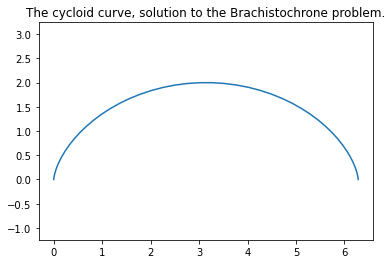

In [10]:
plt.title('The cycloid curve, solution to the Brachistochrone problem.')
plt.axis('equal')
T = np.linspace(0,2*np.pi)
plt.plot(*Cycloid(T));

We introduce a slightly reduced interior interval, since the Brachistochrone problem becomes singular when the object velocity vanishes.

In [11]:
Tint = np.linspace(0.2,2*np.pi-0.4) #Interior interval

Let us emphasize that the Cycloid is not parametrized at constant Euclidean velocity. Indeed
$$
    x(t) = \frac{t^3} 6+ O(t^5), \quad z(t) = \frac {t^2} 2 + O(t^4)
$$
Hence the endpoints of the Cycloid on this interval are extremely close to the singularity of the metric at $z=0$.
This raises a substantial difficulty for fast marching and shooting methods.

In [12]:
Cycloid(Tint[0])

array([0.00133067, 0.01993342])

### 2.2 Numerical solution using the fast marching method

In [13]:
hfmIn = Eikonal.dictIn({
    'model':'Isotropic2',
    'seed':Cycloid(0.2),
    'tip': Cycloid(2.*np.pi-0.2)
})
dx = 0.4 # Use a slightly larger domain, containing the trajectory in its interior
hfmIn.SetRect([[-dx,2.*np.pi+dx],[0,2+dx]],dimx=300)
X,Z = hfmIn.Grid()

In [14]:
hfmIn['cost'] = 1./np.sqrt(Z)

In [15]:
hfmOut = hfmIn.Run()

Field verbosity defaults to 1
Field order defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 0.009577 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45


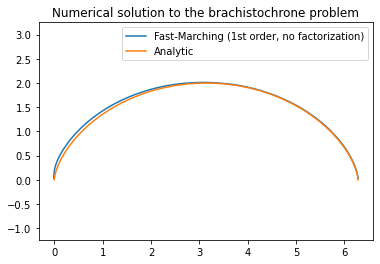

In [16]:
plt.title("Numerical solution to the brachistochrone problem") 
plt.plot(*hfmOut['geodesics'][0],label="Fast-Marching (1st order, no factorization)")
plt.plot(*Cycloid(T),label="Analytic")
plt.axis('equal'); plt.legend();

In [17]:
hfmIn2 = hfmIn.copy()
hfmIn2.update({
    # Improve accuracy
    'order':2,
    'factoringRadius':20,
    
    # Export relevant data
    'exportGeodesicFlow':True,
    'exportValues':True,
})

Introducing source factorization and a higher order method yields a more accurate trajectory.

In [18]:
hfmOut = hfmIn2.Run()

Field verbosity defaults to 1
Field seedRadius defaults to 2
Field factoringPointChoice defaults to Seed
Field exportFactoring defaults to 0
Fast marching solver completed in 0.01156 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45


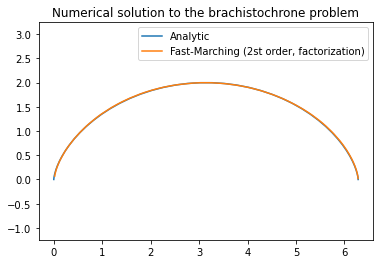

In [19]:
plt.title("Numerical solution to the brachistochrone problem") 
plt.plot(*Cycloid(T),label="Analytic")
plt.plot(*hfmOut['geodesics'][0],label="Fast-Marching (2st order, factorization)")
plt.axis('equal'); plt.legend();

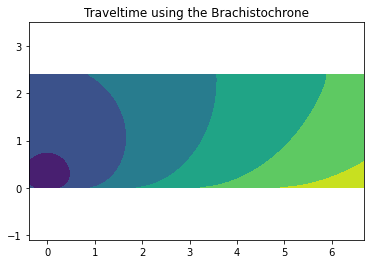

In [20]:
plt.title('Traveltime using the Brachistochrone')
plt.contourf(X,Z,hfmOut['values'])
plt.axis('equal');

### 2.3 Solving Hamilton's equations of motion

Recall that the Hamiltonian is defined as the half square dual metric. For the brachistochrone, it reads
$$
    H(q,p) := \frac z 2 \|p\|^2,
$$
where $q=(x,z)$ is the position, and $p$ is the momentum. In this simple case, the velocity and momentum at a point $q=(x,z)$ are related by the equation
$$
    v = \frac {\partial H}{\partial p} = z p.
$$

For generality, we illustrate this experiment with both the analytic expression of the Hamiltonian, and an interpolated metric.

In [21]:
def Brach_A_(q,p):
    """Analytic Hamiltonian for the brachistochrone problem"""
    return 0.5 * q[1] * (p**2).sum(axis=0)
Brach_A = GenericHamiltonian(Brach_A_)

In [22]:
Brach_I = MetricHamiltonian(Metrics.Isotropic(hfmIn['cost']),grid=hfmIn.Grid(),order=3)

In [23]:
Cycloid(ad.Dense.identity(constant=0.2)).gradient(0)

array([0.01993342, 0.19866933])

In [24]:
t_ad = ad.Dense.identity(constant=0.2)
Cyc_ad = Cycloid(t_ad)
q0 = Cyc_ad.value
v0 = Cyc_ad.gradient(0) # Initial velocity
p0 = v0/q0[1] # Initial impulsion

print(f"Exact hamiltonian flow: {Brach_A.flow(q0,p0)}")
print(f"Interpolated hamiltonian flow: {Brach_I.flow(q0,p0)}")

Exact hamiltonian flow: (array([0.01993342, 0.19866933]), array([ -0.        , -50.16700053]))
Interpolated hamiltonian flow: (array([0.01943866, 0.19373818]), array([ 4.65921484e-15, -5.18012345e+01]))


When using external ODE solvers, which ignore the Hamiltonian structure, one often needs a function which takes as input the concatenated position and impulsion, and returns their concatenated derivatives - the Hamiltonian flow.
This is the purpose of the `.flow_cat` member of the `Hamiltonian` class.

In [25]:
QP_A,dict_A = scipy.integrate.odeint(Brach_A.flow_cat,np.concatenate((q0,p0)),Tint,full_output=True)

The computation is a bit longer with the interpolated hamiltonian. Indeed, the `odeint` routine introduces substantial refinement, due to the lesser smoothness of the interpolated flow.

In [26]:
%%time
QP_I,dict_I = scipy.integrate.odeint(Brach_I.flow_cat,np.concatenate((q0,p0)),Tint,full_output=True)

CPU times: user 3.93 s, sys: 38.8 ms, total: 3.97 s
Wall time: 3.96 s


The ODE with an exact hamiltonian is, clearly, accurate to a very high order. In contrast, the spline interpolation introduces a slight deviation.

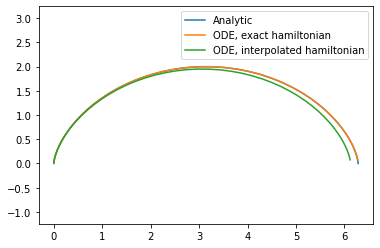

In [27]:
plt.plot(*Cycloid(T),label="Analytic")
plt.plot(*QP_A[:,:2].T,label="ODE, exact hamiltonian")
plt.plot(*QP_I[:,:2].T,label="ODE, interpolated hamiltonian")
plt.axis('equal'); plt.legend();

The Hamiltonian class provides some ODE integration schemes, in particular semi-implicit symplectic schemes. They do take into account the *Hamiltonian* structure, and may therefore offer an interesting alternative to `odeint` in some cases.

In [28]:
%%time
Ttot = Tint[-1]-Tint[0]
# Semi-implicit Euler (symplectic, first order scheme)
Q_Ep,_,_ = Brach_I.integrate(q0,p0,scheme='Euler-p',T=Ttot,niter=3*len(Tint),path=True)

CPU times: user 4.92 s, sys: 36.4 ms, total: 4.96 s
Wall time: 4.88 s


In [29]:
%%time
# Semi-implicit Verlet (symplectic, second order scheme)
Q_Vp,_,_ = Brach_I.integrate(q0,p0,scheme='Verlet-p',T=Ttot,niter=3*len(Tint),path=True)

CPU times: user 5.74 s, sys: 65.8 ms, total: 5.81 s
Wall time: 5.79 s


In [30]:
%%time
# Runge-Kutta (non-symplectic, fourth order scheme)
Q_RK4,_,_ = Brach_I.integrate(q0,p0,scheme='Runge-Kutta-4',T=Ttot,niter=3*len(Tint),path=True)

CPU times: user 3.37 s, sys: 69.3 ms, total: 3.44 s
Wall time: 3.4 s


Here, the Verlet scheme seems to be the most accurate.

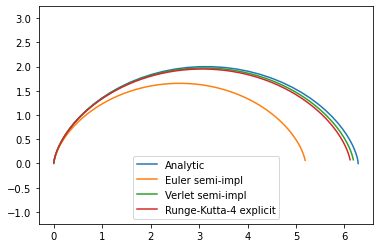

In [31]:
plt.plot(*Cycloid(T),label="Analytic")
plt.plot(*Q_Ep,label="Euler semi-impl")
plt.plot(*Q_Vp,label="Verlet semi-impl")
plt.plot(*Q_RK4,label="Runge-Kutta-4 explicit")

plt.axis('equal'); plt.legend();

### 2.4 Initial momentum from the PDE solution

As discussed in the theoretical section, we use the gradient of the squared distance function as a proxy for final momentum. Since Riemannian metrics are symmetric, we can solve forward in time, only reversing the momentum. 

In [32]:
energy_i,impulsion_i = energy_impulsion_i(hfmIn2,hfmOut,order=3)

In [33]:
q0 = np.array([3.,1.])
p0 = -impulsion_i(q0)
QP = scipy.integrate.odeint(Brach_A.flow_cat,np.concatenate((q0,p0)),np.linspace(0,1.))

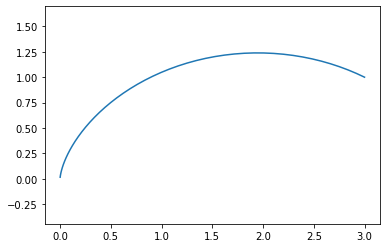

In [34]:
plt.plot(*QP[:,:2].T)
plt.axis('equal');

If the vector dimension `vdim` of the hamiltonian is correctly set, then one can integrate multiple geodesics simultaneously.

In [35]:
Brach_A.vdim=2 # Fix vector space dimension. (Used internally for reshaping purposes.)

np.random.seed(42); nSamples = 10
q0 = np.array([np.random.uniform(0.,2.*np.pi,nSamples),np.random.uniform(0.2,2,nSamples)])
p0 = -impulsion_i(q0)
T = np.linspace(0,1)

#Flatten position and impulsion, as required by odeint
QP = scipy.integrate.odeint(Brach_A.flow_cat,np.concatenate((q0,p0),axis=0).flatten(),T)
#Expand back the solution
Q = QP[:,:2*nSamples].reshape((len(T),2,nSamples))
P = QP[:,2*nSamples:].reshape((len(T),2,nSamples))

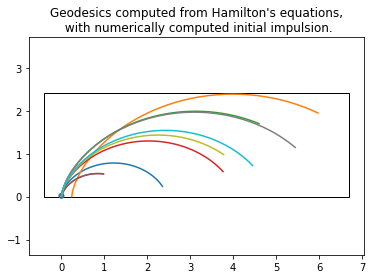

In [36]:
plt.title("Geodesics computed from Hamilton's equations,\n with numerically computed initial impulsion.")
plt.axis('equal'); add_patches(hfmIn)
for i in range(nSamples):
    plt.plot(*Q[:,:,i].T)

Note that one of the geodesics displayed above does *not* correctly reach the seed point. Indeed, that the exact geodesic reaching this tip for this model goes outside of the computational domain. Therefore the numerical geodesic is perturbed by the presence of the domain boundary, which acts as an obstacle. 

### 2.5 The geodesic flow

As discussed in the theoretical section, we integrate the geodesic flow to extract the geodesic.

In [37]:
value_i,flow_i = value_flow_i(hfmIn2,hfmOut,order=3)

In [38]:
q0 = [3.,1.]
T = np.linspace(0,value_i(q0))
Q = scipy.integrate.odeint(flow_i,q0,T[:-1],args=(-1,)) # dropping last time step, to avoid leaving domain

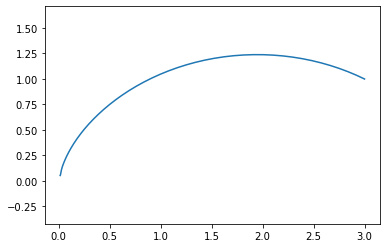

In [39]:
plt.plot(*Q.T)
plt.axis('equal');

It is often more convenient to compute several geodesics simulatenously. In Python, and using tensor based programming, this may also be more computationally efficient. However, one needs for that purpose some flattening and reshaping utilities, given the constraints of the `scipy.intergrate.odeint` routine.

In [40]:
flow_r = reshape_input_flatten_output(flow_i,2) # Flow reshaped

In [41]:
np.random.seed(42); nSamples = 10
q0 = np.array([np.random.uniform(0.,2.*np.pi,nSamples),np.random.uniform(0.2,2,nSamples)])
T = np.linspace(0,1)
Q = scipy.integrate.odeint(flow_r,q0.flatten(),T[:-1],args=(-value_i(q0),)) #Dropping last time step to avoid leaving domain

All the computed geodesics end at the desired endpoint, including the one perturbed by the presence of the domain boundary. This is in contrast with the approach based on geodesic shooting using Hamilton's equations of motion, which fails in such cases, see the previous subsection.

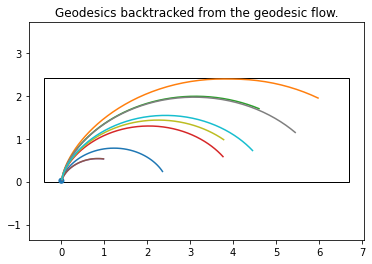

In [42]:
plt.title("Geodesics backtracked from the geodesic flow.")
plt.axis('equal'); add_patches(hfmIn)
for i in range(nSamples):
    plt.plot(Q[:,i],Q[:,i+nSamples])

## 3. Riemannian metrics, and the fastest slide on a landscape

We consider a variant of the Brachistochrone problem, where the purpose is to build the fastest slide between two given points *on a given landscape* (two dimensional). Again, we neglect friction.

The total energy of a point of mass $m$, at height $h$, velocity $\mathbf{v}$, in a gravitational field g, as before
$$
    E = m g h + \frac 1 2 m \|\mathbf{v}\|^2
$$
The total energy is conserved along the trajectory (no friction assumption), and the object velocity is therefore determined by its height. Denoting by $\mathbf{z}$ the vertical coordinate, possibly shifted, inverted and rescaled w.r.t. the height $h$, one finds that
$$
    \frac{\|\mathbf{v}\|^2}{\mathbf{z}}
$$
is constant and positive along the trajectory. In particular, positions for which $z\leq 0$ are not accessible. (These positions are too elevated, a.k.a have an excessive potential energy to be accessed. Note that the vertical axis was reversed.)

Let us introduce a two dimensional domain $\Omega$, and a landscape function $z : \Omega \mapsto R$. 
The vertical coordinate $\mathbf{z}$ and three dimensional velocity $\mathbf{v}$ are determined by the planar position $q \in \Omega$ and velocity $v \in R^2$ by 
$$
    \mathbf{z} = z(q), \qquad \mathbf{v} = \begin{pmatrix} v \\ <\nabla z(q),v> \end{pmatrix}.
$$

As a result, the (squared) Riemannian metric underlying the brachistochrone on a landscape problem reads
$$
    F_q(v)^2 = \frac{\|\mathbf{v}\|^2}{\mathbf{z}} = \frac{ \|v\|^2 + <\nabla z(q),v>^2}{z(q)},
$$
in matrix form
$$
    M(q) := \frac{\mathrm{Id} + \nabla z(q) \nabla z(q)^T}{z(q)}.
$$
Note that the hamiltonian is defined as the half-squared dual metric.


**Implementation note.** We use here an analytic height map, and compute its gradient via automatic differentiation.
Alternatively, one can estimate the gradient using finite differences, see the closely relateted example in the [notebook on Riemannian metrics](Riemannian.ipynb).

In [43]:
def Slide_Z(q):
    """(Opposite of the) landscape elevation where the slide is built"""
    return 2+2*np.sin(q[0])*np.sin(q[1])

def Slide_M(q,ret_walls=False,ztol=1e-2,z0=0) : 
    """Riemannian metric of the slide on landscape problem, in matrix form. (Analytic expression)"""
    # Differentiate elevation
    q_ad = ad.Dense.identity(constant=q,shape_free=(2,))
    z_ad = z0+Slide_Z(q_ad)
    
    # Deal with inaccessible regions
    if ztol is not None:
        walls = z_ad<=ztol
        z_ad[walls]=1. # Dummy non-zero value
    
    # Produce riemannian tensor
    Id = fd.as_field(np.eye(2),q.shape[1:])
    M = ( Id + lp.outer_self(z_ad.gradient()) ) / z_ad.value
    
    return (M,walls) if ret_walls else M

def Slide_A_(q,p,**kwargs):
    """Hamiltonian of the slide on landscape problem. (Analytic expression)."""
    return lp.dot_VV(p, lp.solve_AV(Slide_M(q,**kwargs),p)) / 2.

### 3.1 Numerical solution using the fast-marching method

The computational domain is $[-2\pi,2\pi]^2$.

In [44]:
hfmIn = Eikonal.dictIn({
    'model':'Riemann2',
    'arrayOrdering':'RowMajor',
    'seeds': [(0,2)],
})

hfmIn.SetRect([[-2*np.pi,2*np.pi],[-2*np.pi,2*np.pi]],dimx=800)
grid = hfmIn.Grid()
hfmIn.SetUniformTips((6,6)) # Regularly spaced tips

metric_tensors,hfmIn['walls'] = Slide_M(grid,ret_walls=True,z0=-0.5)
hfmIn['metric'] = Metrics.Riemann(metric_tensors)

The Riemannian metric is (not so strongly) anisotropic. See below largest length distortion, at any given point, depending on the direction.

In [45]:
print(f"Largest local anisotropic length distortion : {np.max(hfmIn['metric'].anisotropy())}")

Largest local anisotropic length distortion : 2.2359576383209347


In [46]:
hfmOut = hfmIn.Run()

Field verbosity defaults to 1
Field order defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 0.404813 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45


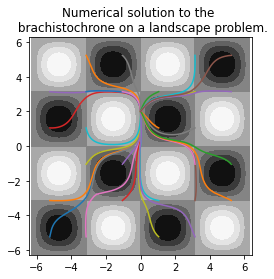

In [47]:
plt.figure(figsize=(4,4)); plt.axis('equal')
plt.title("Numerical solution to the \n brachistochrone on a landscape problem.") 
plt.contourf(*grid,Slide_Z(grid),cmap='Greys')
for geo in hfmOut['geodesics']: plt.plot(*geo)

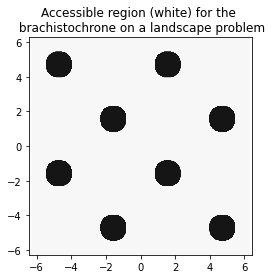

In [48]:
plt.figure(figsize=(4,4)); plt.axis('equal')
plt.title('Accessible region (white) for the \n brachistochrone on a landscape problem')
plt.contourf(*grid,hfmIn['walls'],cmap='Greys');

As usual, one can improve the accuracy of the fast marching method by using source factorization, a second order accurate scheme, and spreading the seed over a few pixels.

In [49]:
hfmIn2 = hfmIn.copy()
hfmIn2.update({
    # Improve accuracy
    'order':2,
    'factoringRadius':30,
    
    # Export relevant data
    'exportGeodesicFlow':True,
    'exportValues':True,
})

In [50]:
hfmOut = hfmIn2.Run()

Field verbosity defaults to 1
Field seedRadius defaults to 2
Field factoringPointChoice defaults to Seed
Field exportFactoring defaults to 0
Fast marching solver completed in 0.503348 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45


### 3.2 Integrating the flow

As before, integrating the flow the most robust approach to computing the minimizing geodesics - when the eikonal equation has been solved.

Spline nterpolation in degree >1 requires that the array contains neither infinite nor nan values.

In [51]:
hfmOut['values'] [hfmIn['walls'] ] = 0. # Insert dummy values in inaccessible places, to allow interpolation
value_i,flow_i = value_flow_i(hfmIn2,hfmOut,order=3)

flow_r = reshape_input_flatten_output(flow_i,2) # Flow reshaped

We only consider the tips which lie in the accessible regions. Numerical integration with scipy tends to be a bit long, up to a minute, possibly due to the lack of smoothness of the interpolated flow.

In [52]:
%%time
walls = Interp(grid,hfmIn['walls'],order=1)
q0 = hfmIn['tips'].copy().T
q0 = q0[:,walls(q0)==0.]
nSamples=q0.shape[1]

T = np.linspace(0,1)
Q = scipy.integrate.odeint(flow_r,q0.flatten(),T[:-1],args=(-value_i(q0),)) # Dropping last time step

CPU times: user 10.4 s, sys: 45.7 ms, total: 10.4 s
Wall time: 10.5 s


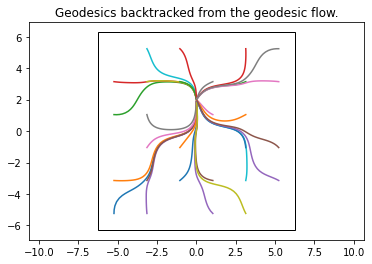

In [53]:
plt.title("Geodesics backtracked from the geodesic flow.")
plt.axis('equal'); add_patches(hfmIn)
for i in range(nSamples):
    plt.plot(Q[:,i],Q[:,i+nSamples])

### 3.3 Geodesic shooting

**Using the analytic hamiltonian** Let us introduce the analytic Hamiltonian, as well as the energy of the paths and its gradient the  impulsion.

In [54]:
Slide_A = GenericHamiltonian(lambda q,p:Slide_A_(q,p,z0=-0.5,ztol=None),
                              vdim=2,disassociate_ad=True)

In [55]:
energy_i,impulsion_i = energy_impulsion_i(hfmIn2,hfmOut,order=3)

In [56]:
p0 = -impulsion_i(q0)
T = np.linspace(0,1)

QP = scipy.integrate.odeint(Slide_A.flow_cat,np.concatenate((q0,p0),axis=0).flatten(),T)
Q = QP[:,:2*nSamples].reshape((len(T),2,nSamples))

Most geodesics obtained from geodesic shooting reach the initial seed, but not all. Long paths that come close to the inaccessibe regions raise most difficulties.

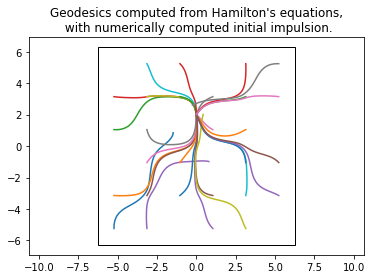

In [57]:
plt.title("Geodesics computed from Hamilton's equations,\n with numerically computed initial impulsion.")
plt.axis('equal'); add_patches(hfmIn)
for i in range(nSamples):
    plt.plot(*Q[:,:,i].T)

**Interpolated hamiltonian.** Using the interpolated metric does note work so well in the above example. This might be due to the discontinuities in the metric at the boundaries of the inaccessible, which pollute the interpolation.

For this reason, we modify the problem using a positive value of $z_0$, so that all points in the domain are accessible.

In [58]:
metric_tensors = Slide_M(grid,z0=1)

hfmIn2['metric'] = Metrics.Riemann(metric_tensors)
hfmIn2.pop('walls',None);

Slide_I = MetricHamiltonian(hfmIn2['metric'],grid=grid)

The metric anisotropy is unchanged, but it is now everywhere defined, and there are no obstacles.

In [59]:
np.max(hfmIn2['metric'].anisotropy())

2.2359576383209347

In [60]:
hfmOut = hfmIn2.Run()

Field verbosity defaults to 1
Field seedRadius defaults to 2
Field factoringPointChoice defaults to Seed
Field exportFactoring defaults to 0
Fast marching solver completed in 0.524347 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45


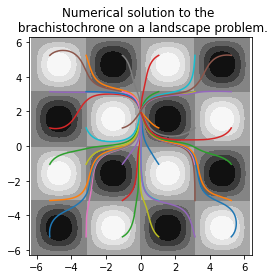

In [61]:
plt.figure(figsize=(4,4)); plt.axis('equal')
plt.title("Numerical solution to the \n brachistochrone on a landscape problem.") 
plt.contourf(*grid,Slide_Z(grid),cmap='Greys')
for geo in hfmOut['geodesics']: plt.plot(*geo)

In [62]:
energy_i,impulsion_i = energy_impulsion_i(hfmIn2,hfmOut,order=3)

We use the standard Runge-Kutta fourth order to solve Hamilton's equations of motion. Indeed, strangely, `scipy.odeint` produces impredictable and often very long run times on this test case.

In [63]:
q0 = hfmIn['tips'].copy().T
p0 = -impulsion_i(q0)
nSamples=q0.shape[1]

# Runge-Kutta (non-symplectic, fourth order scheme)
Q_RK4,_,_ = Slide_I.integrate(q0,p0,scheme='Runge-Kutta-4',T=1,niter=200,path=True)

As before, more geodesics reach the initial seed. Yet some of the longest ones, going through regions where the metric varies strongly, are misled. For those, a more accurate (final) impulsion would be needed to meet the seed, or a refinement using an optimization method of this numerical approximation.

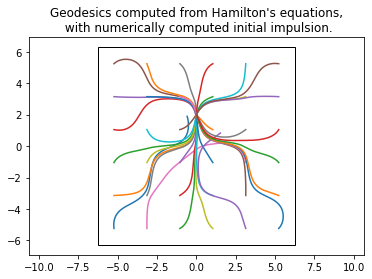

In [64]:
plt.title("Geodesics computed from Hamilton's equations,\n with numerically computed initial impulsion.")
plt.axis('equal'); add_patches(hfmIn)
for i in range(nSamples):
    plt.plot(*Q_RK4[:,:,i])